# Fine Tuning HuggingFace `bert-base-uncased` for Yelp customer review prediction

<img src="2022-09-30-22-51-29.png" alt="drawing" width="500"/>

## [Link to Dataset](https://www.kaggle.com/datasets/omkarsabnis/yelp-reviews-dataset)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Fri Sep 30 11:53:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers tokenizers -q

In [4]:
from dataloader import *
from modeling import *

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Read Dataset

In [5]:
csv_file_path = '../input/yelp.csv' #local machine

In [6]:
df = pd.read_csv(csv_file_path)
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [7]:
sorted(df.stars.unique())

[1, 2, 3, 4, 5]

In [8]:

# Make the Number of stars given as customer review to a 0-based index
# i.e. convert 1-5 scale to 0-4 scale
def map_sentiment_scores(star_number):
    star_number = int(star_number)
    if star_number == 1:
        return 0
    elif star_number == 2:
        return 1
    elif star_number == 3:
        return 2
    elif star_number == 4:
        return 3
    elif star_number == 5:
        return 4

    
df['stars'] = df.stars.apply(map_sentiment_scores)

In [9]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,4,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,4,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,3,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,4,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,4,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [10]:
sorted(df.stars.unique())

[0, 1, 2, 3, 4]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, '1-Star'),
 Text(0, 0, '2-Star'),
 Text(0, 0, '3-Star'),
 Text(0, 0, '4-Star'),
 Text(0, 0, '5-Star')]

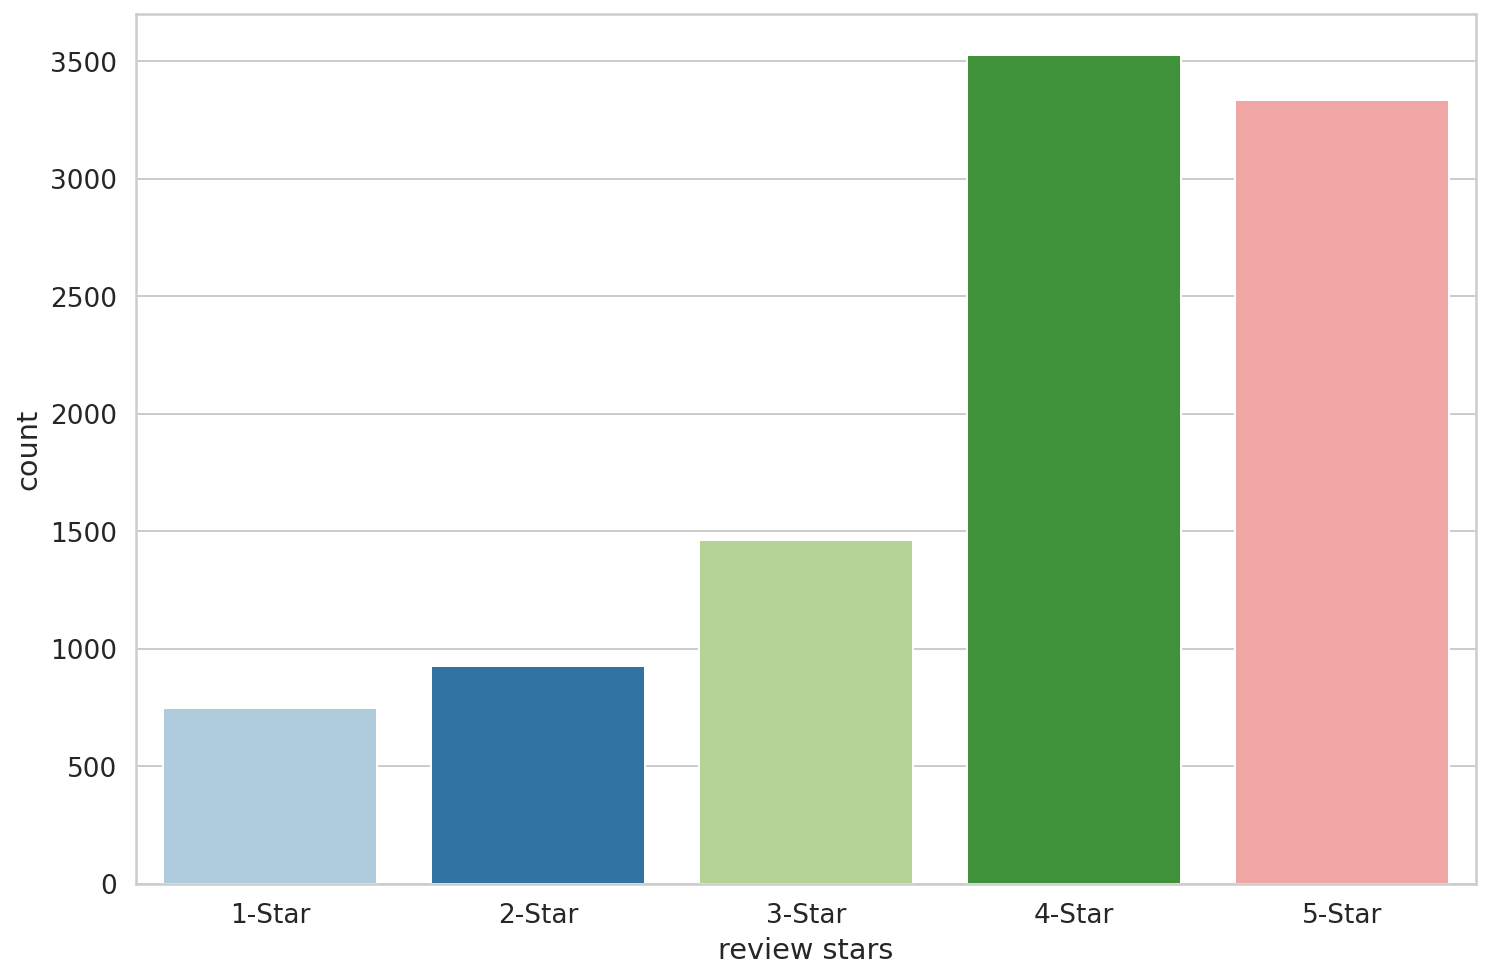

In [11]:
class_names = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star' ]

ax = sns.countplot(df.stars)

plt.xlabel('review stars')

ax.set_xticklabels(class_names)


## `text` and 'stars` columns will be the features and targets respectively down below


```py
reviews = df.text.to_list(), 
targets = df.stars.to_list(), 

```

# Model

## Define Transformer and Tokenizer

#### The encode_plus and encode functions tokenize your texts and prepare them in a proper input format of the BERT model.

The main difference is stemming from the additional information that `encode_plus` is providing. 


The [`encode()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode):

> Converts a string in a sequence of ids (integer), using the tokenizer and vocabulary.
> Same as doing `self.convert_tokens_to_ids(self.tokenize(text))`.

While the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus):

> Returns a dictionary containing the encoded sequence or sequence pair
> **and additional information**: the mask for sequence classification and
> the overflowing elements if a `max_length` is specified.

So the difference lies in the additionally encoded information, specifically the input mask. 





In [12]:
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

# Tokenization and encoding on a Sample Text

In [13]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding=True,
    return_attention_mask=True,
    return_tensors='pt')  # Return PyTorch tensors)

print(f'Encoding keys: {encoding.keys()}')
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]
Encoding keys: dict_keys(['input_ids', 'attention_mask'])
17
tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134, 1012,  102])
17
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
['[CLS]', 'when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.', '[SEP]']


### EDA of token counts in the reviews dataset

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

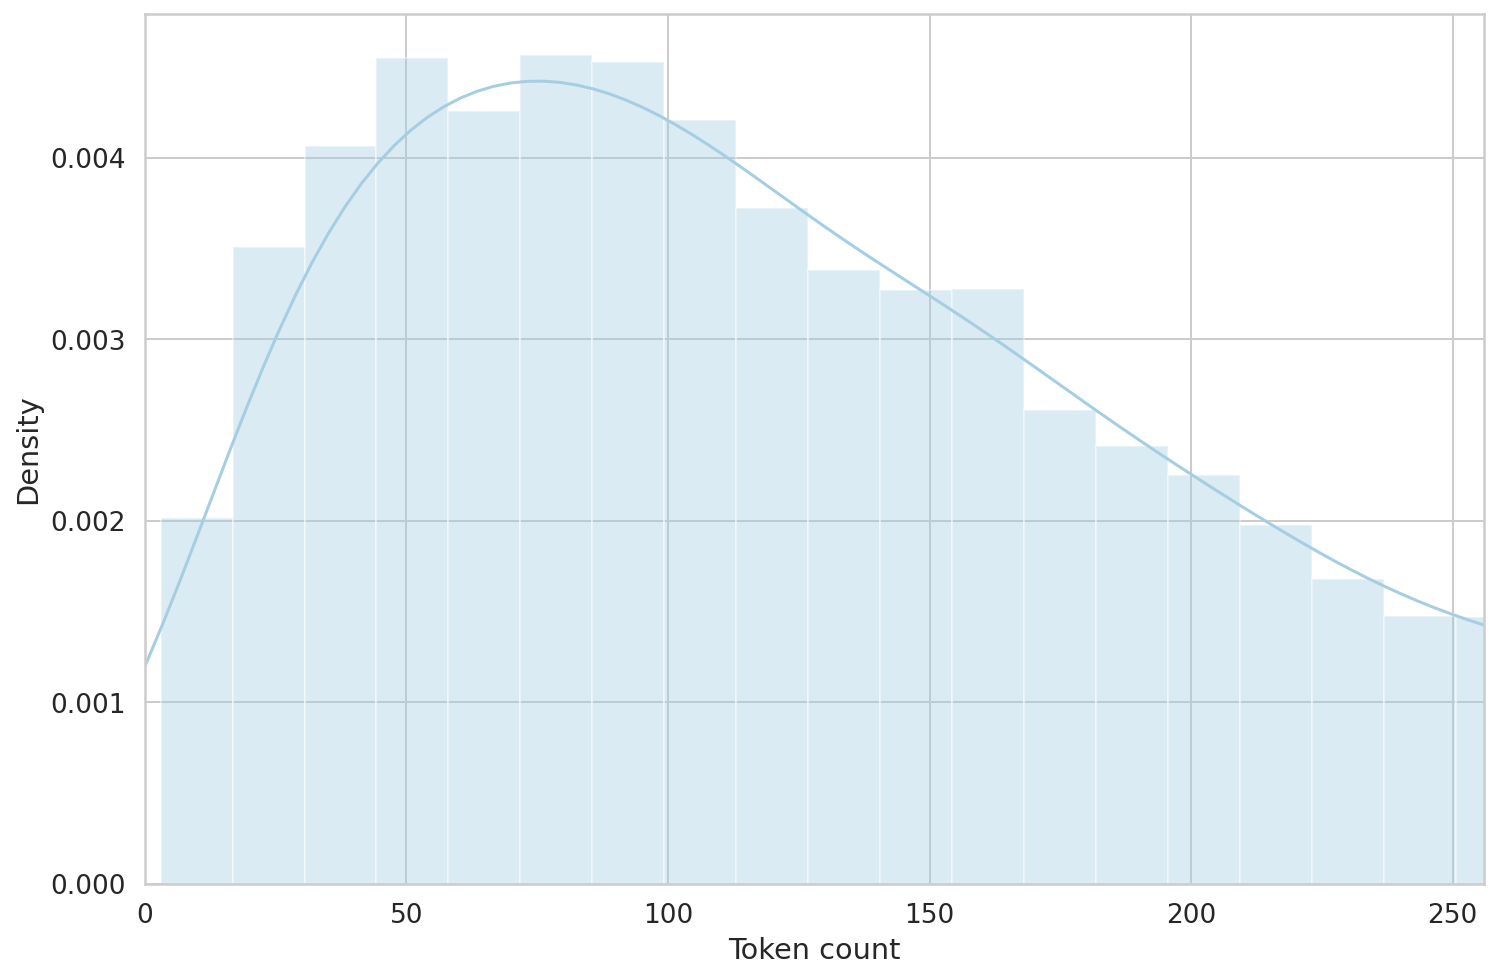

In [14]:
token_lens = []

for txt in df.text:
    tokens = tokenizer.encode(txt, truncation=True, max_length=512)
    token_lens.append(len(tokens))


sns.distplot(token_lens)

plt.xlim([0,256])

plt.xlabel('Token count')

# Dataset Utility Class

In [16]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(7000, 10) (1500, 10) (1500, 10)


In [17]:
train_data_loader = create_data_loader(df_train, tokenizer)
val_data_loader = create_data_loader(df_val, tokenizer, include_raw_text=True)
test_data_loader = create_data_loader(df_test, tokenizer, include_raw_text=True)

In [18]:
for d in val_data_loader:
    print(d.keys())
    
# dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])

dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention

In [19]:
#Testing to see if the data loader works appropriately
data = next(iter(train_data_loader))

print(data.keys()) # dict_keys(['input_ids', 'attention_mask', 'targets'])

print(data['input_ids'].shape) # torch.Size([16, 512])

print(data['attention_mask'].shape) # torch.Size([16, 512])

print(data['targets'].shape) # torch.Size([16])

dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Model Utility Class

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

# Just An evaluation run of the model
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
F.softmax(model(input_ids,attention_mask), dim = 1)


# Training

In [22]:
EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr= 1e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, 
    num_training_steps=total_steps)

# For multi-class classification you would usually just use nn.CrossEntropyLoss 
loss_fn = nn.CrossEntropyLoss().to(device)


## Training Loop

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
  
    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  

# Model Evaluation on test_data_loader

              precision    recall  f1-score   support

      1-Star       0.70      0.55      0.61       100
      2-Star       0.40      0.41      0.40       110
      3-Star       0.45      0.38      0.41       231
      4-Star       0.55      0.56      0.56       567
      5-Star       0.63      0.68      0.65       492

    accuracy                           0.56      1500
   macro avg       0.54      0.52      0.53      1500
weighted avg       0.56      0.56      0.56      1500



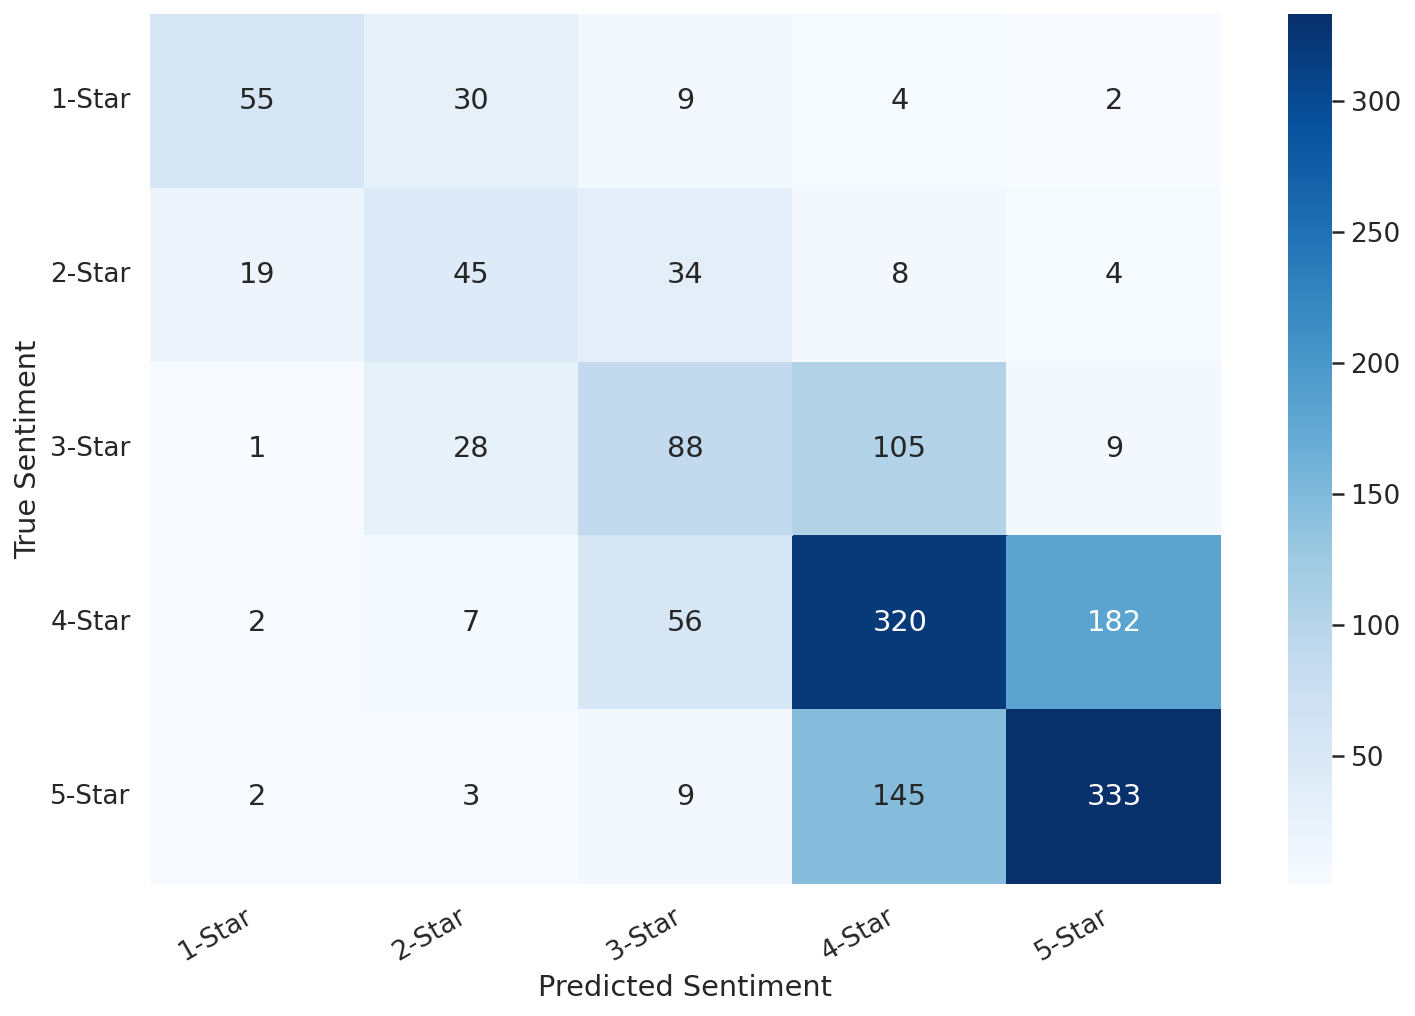

In [31]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

In [33]:
review_text = "I could share photos seamlessly with this app"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')



Review text: I could share photos seamlessly with this app
Sentiment  : 5-Star


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [34]:
review_text = "I could share photos seamlessly with this app, but the UI could be better"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I could share photos seamlessly with this app, but the UI could be better
Sentiment  : 3-Star
